#Implement Deep Neural Network (DNN) with TensorFlow
In this lab, we'll see how to build a simple deep neural network model using the Keras sequential api and feature columns.

In [38]:
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.models import Sequential

print(tf.__version__)

2.12.0


##Load the raw data
**Note** Please change the path to your dataset's path.

We will use the taxifare dataset, using the CSV files that we created in the first notebook of this sequence.

In [39]:
CSV_COLUMNS = [
    "fare_amount",
    "pickup_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
    "key",
]
LABEL_COLUMN = "fare_amount"
DEFAULTS = [[0.0], ["na"], [0.0], [0.0], [0.0], [0.0], [0.0], ["na"]]
UNWANTED_COLS = ["pickup_datetime", "key"]

def features_and_labels(df):
    label = df[LABEL_COLUMN]
    features = df.drop(columns=[LABEL_COLUMN] + UNWANTED_COLS)
    return features, label

def create_dataset(path, batch_size=1, mode="eval"):
    # Read CSV file and create dataframe
    df = pd.read_csv(path, header=None, names=CSV_COLUMNS)

    # Seperate the labels and the features
    features, labels = features_and_labels(df)

    # Convert to TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((features.to_dict('list'), labels.values))

    if mode == "train":
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    dataset = dataset.batch(batch_size)

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)

    return dataset


##Building Keras DNN model

In [40]:
INPUT_COLS = [
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
]

# Create input layer of feature columns
feature_columns = {
    colname: tf.feature_column.numeric_column(colname) for colname in INPUT_COLS
}

In [41]:
# Define the model
model = Sequential([
        DenseFeatures(feature_columns=feature_columns.values()),
        Dense(units=32, activation="relu", name="h1"),
        Dense(units=8, activation="relu", name="h2"),
        Dense(units=1, activation="linear", name="output"),
    ])

In [42]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


# Compile the keras model
model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

##Train the model

In [43]:
TRAIN_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    path="/content/taxi-train.csv", batch_size=TRAIN_BATCH_SIZE, mode="train"
)

evalds = create_dataset(
    path="/content/taxi-valid.csv", batch_size=1000, mode="eval"
).take(NUM_EVAL_EXAMPLES // 1000)

In [44]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

LOGDIR = "./taxi_trained"
history = model.fit(
    x=trainds,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EVALS,
    validation_data=evalds,
    callbacks=[TensorBoard(LOGDIR)],
)

Epoch 1/50


1/1 [==============================] - ETA: 0s - loss: 2029.2469 - rmse: 45.0472 - mse: 2029.2469

1/1 [==============================] - 1s 1s/step - loss: 2029.2469 - rmse: 45.0472 - mse: 2029.2469 - val_loss: 1904.9513 - val_rmse: 43.6450 - val_mse: 1904.9513
Epoch 2/50
1/1 [==============================] - 0s 36ms/step - loss: 1937.8363 - rmse: 44.0209 - mse: 1937.8363 - val_loss: 1796.6268 - val_rmse: 42.3858 - val_mse: 1796.6268
Epoch 3/50
1/1 [==============================] - 0s 54ms/step - loss: 1829.8650 - rmse: 42.7769 - mse: 1829.8650 - val_loss: 1692.7306 - val_rmse: 41.1419 - val_mse: 1692.7306
Epoch 4/50
1/1 [==============================] - 0s 47ms/step - loss: 1717.5920 - rmse: 41.4438 - mse: 1717.5920 - val_loss: 1593.2432 - val_rmse: 39.9144 - val_mse: 1593.2432
Epoch 5/50
1/1 [==============================] - 0s 43ms/step - loss: 1623.8597 - rmse: 40.2971 - mse: 1623.8597 - val_loss: 1498.1478 - val_rmse: 38.7048 - val_mse: 1498.1478
Epoch 6/50
1/1 [==============================] - 0s 50ms/step - loss: 1486.4456 - rmse: 38.5545 - mse: 1486.4456 - val_loss: 14

##Model evaluation

In [45]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features_5 (DenseFeat  multiple                 0         
 ures)                                                           
                                                                 
 h1 (Dense)                  multiple                  192       
                                                                 
 h2 (Dense)                  multiple                  264       
                                                                 
 output (Dense)              multiple                  9         
                                                                 
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


<Axes: >

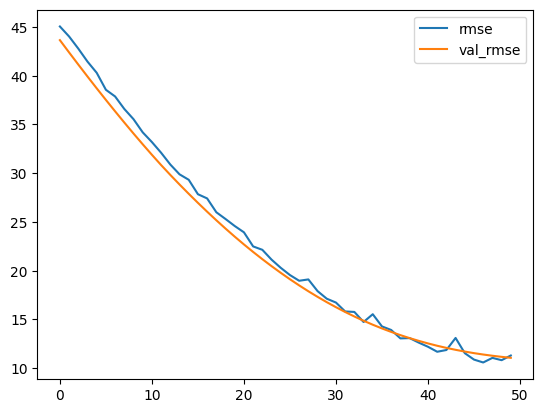

In [46]:
RMSE_COLS = ["rmse", "val_rmse"]

pd.DataFrame(history.history)[RMSE_COLS].plot()

<Axes: >

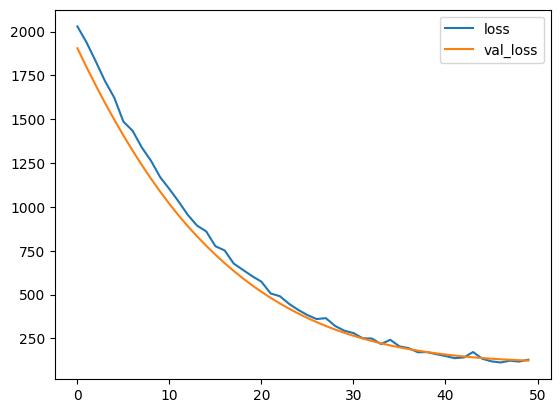

In [47]:
LOSS_COLS = ["loss", "val_loss"]

pd.DataFrame(history.history)[LOSS_COLS].plot()